# Q1

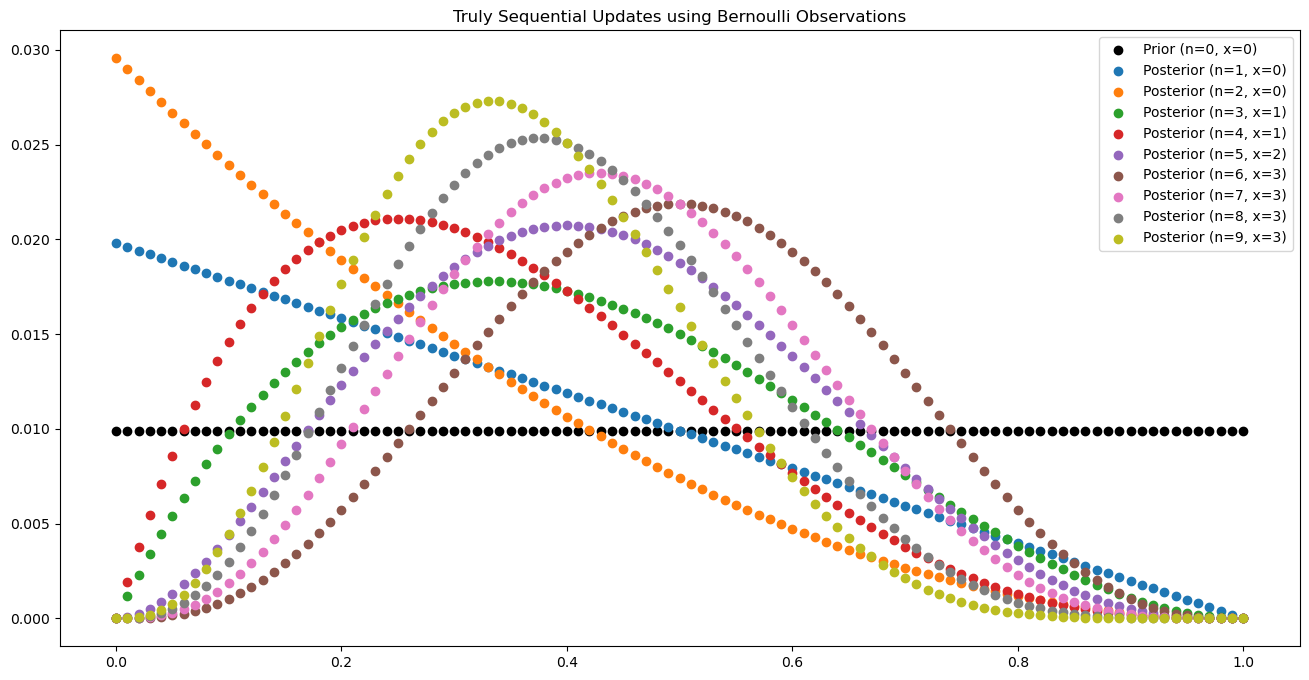

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Discretize the parameter space: 0, 1/100, 2/100, ..., 1
parameter_domain = np.linspace(0, 1, 101)

# Initialize a uniform prior distribution over these 101 points
prior = np.ones(101) / 101

# Observations (each observation is either 0 or 1)
observations = [0, 0, 1, 0, 1, 1, 0, 0, 0]

# Counters: n is the total number of observations so far, 
# x is the total number of successes so far.
n, x = 0, 0

plt.figure(figsize=(16, 8))
# Plot the initial prior
plt.scatter(parameter_domain, prior, label=f"Prior (n={n}, x={x})", color='black')
plt.title("Truly Sequential Updates using Bernoulli Observations")

# Perform the sequential update after each observation
for obs in observations:
    # Increase the total count by 1
    n += 1
    # Increase the number of successes by the current observation value
    x += obs
    
    # Unnormalized posterior = prior * likelihood for the current observation
    # If obs == 1, likelihood is theta; if obs == 0, likelihood is (1 - theta).
    posterior_unnormalized = prior * (parameter_domain ** obs) * ((1 - parameter_domain) ** (1 - obs))
    
    # Normalize the posterior so that its total sum is 1
    posterior = posterior_unnormalized / np.sum(posterior_unnormalized)
    
    # Plot the posterior distribution
    plt.scatter(parameter_domain, posterior, label=f"Posterior (n={n}, x={x})")
    
    # The current posterior becomes the prior for the next update
    prior = posterior

plt.legend()
plt.show()


$
\text{Since the prior is uniform on }[0,1]\text{ (i.e.\ Beta}(1,1)\text{), 
the posterior after observing }n\text{ Bernoulli trials with }x\text{ successes is:}
$
$
p(\theta \mid x,n) \;=\; \mathrm{Beta}\!\bigl(\theta \mid x+1,\;n-x+1\bigr).
$

$
\textbf{Posterior: } p(\theta \mid x,n) 
= \mathrm{Beta}\bigl(x+1,\;n - x +1\bigr).
$
$
\text{In other words, with the shape-parameterization, we have: }
\alpha = x + 1,\quad \beta = (n - x) + 1.
$
$
\text{Hence the posterior PDF is } 
p(\theta \mid x,n)
= \frac{\Gamma\bigl(\alpha+\beta\bigr)}{\Gamma(\alpha)\,\Gamma(\beta)} 
\,\theta^{\,\alpha - 1}
\,(1 - \theta)^{\,\beta - 1}
,\quad 0 \le \theta \le 1.
$


# Q2

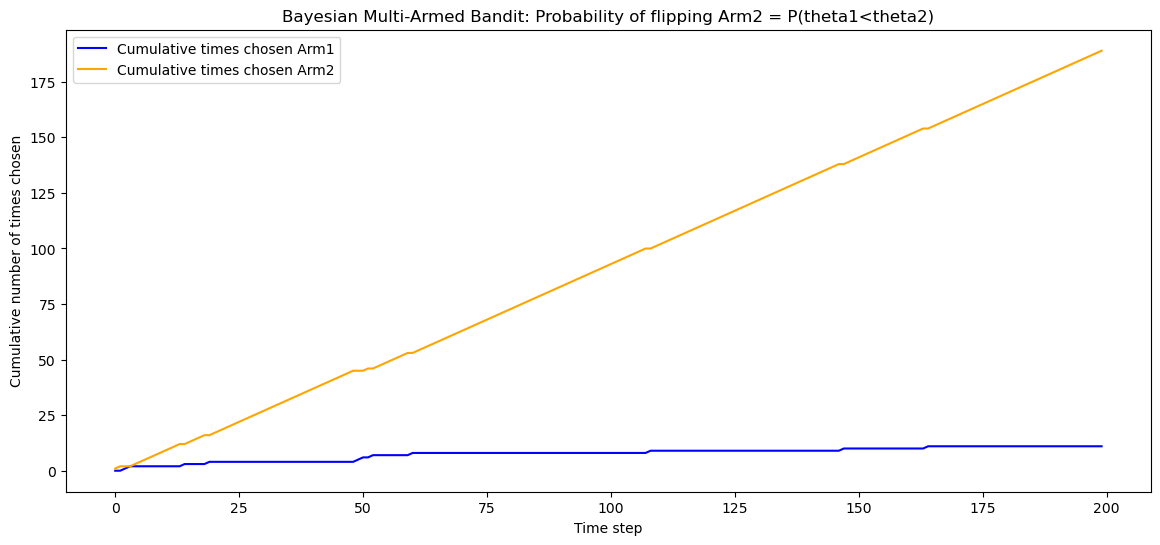

Final estimates for arm1: alpha1=2, beta1=11, => mean=0.15384615384615385
Final estimates for arm2: alpha2=112, beta2=79, => mean=0.5863874345549738
Ground truth: theta1_true=0.3, theta2_true=0.6


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_dist

def approximate_prob_theta1_less_than_theta2(a1, b1, a2, b2, num_samples=10000):
    """
    Approximate P(theta1 < theta2) by Monte Carlo (蒙特卡洛 Monte Carlo) sampling
    from Beta(a1, b1) and Beta(a2, b2).
    """
    samples_1 = np.random.beta(a1, b1, size=num_samples)
    samples_2 = np.random.beta(a2, b2, size=num_samples)
    return np.mean(samples_1 < samples_2)

# True success probabilities for arm1 and arm2
theta1_true = 0.3
theta2_true = 0.6

# Initialize counters for each arm:
# n_j = total flips, x_j = number of successes
n1, x1 = 0, 0
n2, x2 = 0, 0

# Hyperparameters for Beta prior (starting with Beta(1,1))
alpha1, beta1 = 1, 1
alpha2, beta2 = 1, 1

# We'll run for m steps
m = 200

# Keep track of which arm was chosen each step
chosen_arms = []

for t in range(m):
    # Compute P(theta1 < theta2) given current posterior
    p_1_less_2 = approximate_prob_theta1_less_than_theta2(alpha1, beta1, alpha2, beta2)
    
    # Decide which arm to flip:
    # with probability p_1_less_2 => flip arm2, else flip arm1
    if np.random.rand() < p_1_less_2:
        # Flip arm2
        chosen_arm = 2
        # Generate a success/fail according to theta2_true
        outcome = (np.random.rand() < theta2_true)
        # Update counts
        n2 += 1
        x2 += outcome
        # Update posterior parameters
        alpha2 = x2 + 1
        beta2 = (n2 - x2) + 1
    else:
        # Flip arm1
        chosen_arm = 1
        # Generate a success/fail according to theta1_true
        outcome = (np.random.rand() < theta1_true)
        # Update counts
        n1 += 1
        x1 += outcome
        # Update posterior parameters
        alpha1 = x1 + 1
        beta1 = (n1 - x1) + 1
    
    chosen_arms.append(chosen_arm)

# Plot results
plt.figure(figsize=(14,6))

# 1) plot how many times each arm was chosen up to step t
times_chosen_arm1 = np.cumsum([1 if a == 1 else 0 for a in chosen_arms])
times_chosen_arm2 = np.cumsum([1 if a == 2 else 0 for a in chosen_arms])

plt.plot(times_chosen_arm1, label='Cumulative times chosen Arm1', color='blue')
plt.plot(times_chosen_arm2, label='Cumulative times chosen Arm2', color='orange')
plt.title("Bayesian Multi-Armed Bandit: Probability of flipping Arm2 = P(theta1<theta2)")
plt.xlabel("Time step")
plt.ylabel("Cumulative number of times chosen")
plt.legend()
plt.show()

print(f"Final estimates for arm1: alpha1={alpha1}, beta1={beta1}, => mean={alpha1/(alpha1+beta1)}")
print(f"Final estimates for arm2: alpha2={alpha2}, beta2={beta2}, => mean={alpha2/(alpha2+beta2)}")
print(f"Ground truth: theta1_true={theta1_true}, theta2_true={theta2_true}")

# Q3

1. **Problem Setup**  
     We have three entities (arms), each yielding binary outcomes with different probabilities of success. We want to compare two analyses on the same data:
     - **Analysis 1**: Treat each entity independently using Beta-Binomial updates.  
     - **Analysis 2**: Treat all three entities together in a single Dirichlet-Multinomial framework.

  2. **Code Explanation**  
     Below is an illustrative Python script. It simulates a multi-armed bandit setting where each entity is randomly chosen (based on some sampling rule) for observation, then updates either the independent Beta-Binomial or joint Dirichlet-Multinomial posterior. We collect posterior means and plot them to visually compare both approaches.

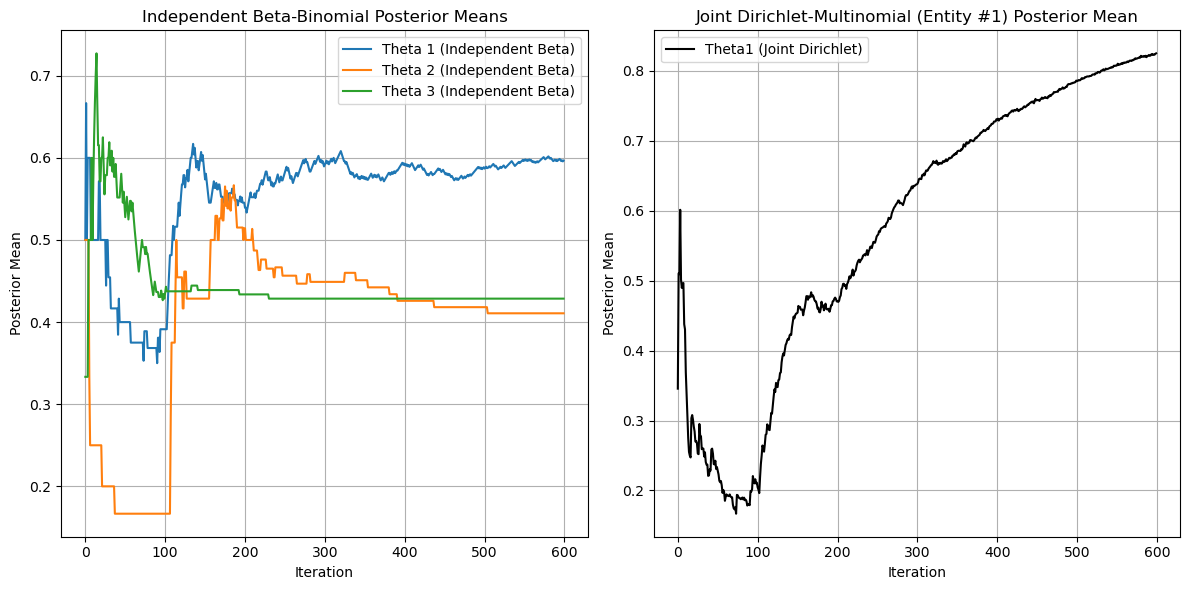

Final Posterior Means (Independent Beta-Binomial):
  Entity 1: 0.597
  Entity 2: 0.411
  Entity 3: 0.429

Final Posterior Mean for Entity #1 (Joint Dirichlet): 0.825


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, dirichlet

# True success probabilities for each of the three entities
theta_true = [0.6, 0.4, 0.5]

# Prior parameters for Beta distributions (Analysis 1: Independent)
alpha_prior = [1, 1, 1]  
beta_prior  = [1, 1, 1]

# Counters for total trials (n) and successes (x) for each entity
n = [0, 0, 0]
x = [0, 0, 0]

# Number of iterations in the simulation
m = 600
# Number of samples used for Monte Carlo estimates
num_samples = 1000
# Small positive constant for Dirichlet stability
epsilon = 1e-6

# We'll track posterior mean estimates over time
posterior_means_independent = [[] for _ in range(3)]  # for Beta-Binomial
posterior_means_joint = []                            # for Dirichlet-Multinomial

plt.figure(figsize=(12, 6))

for t in range(m):
    # ----- Analysis 1: Independent Beta-Binomial -----
    # Draw samples from each entity's Beta posterior
    theta_samples = [
        beta.rvs(alpha_prior[i] + x[i], beta_prior[i] + n[i] - x[i], size=num_samples)
        for i in range(3)
    ]
    
    # Estimate which entity is the best by checking #1 vs #2 vs #3
    # (For demonstration, we decide to choose among them based on
    # the probability that each is better than the others, an ad-hoc rule.)
    prob_1_best = np.mean((theta_samples[0] > theta_samples[1]) & (theta_samples[0] > theta_samples[2]))
    prob_2_best = np.mean((theta_samples[1] > theta_samples[0]) & (theta_samples[1] > theta_samples[2]))
    
    # Decide which entity to sample next
    draw = np.random.rand()
    if draw < prob_1_best:
        chosen = 0
    elif draw < prob_1_best + prob_2_best:
        chosen = 1
    else:
        chosen = 2
    
    # Simulate success/failure based on the chosen entity's true probability
    outcome = (np.random.rand() < theta_true[chosen])
    n[chosen] += 1
    x[chosen] += outcome
    
    # Record the posterior mean for each entity in Analysis 1
    for i in range(3):
        alpha_i = alpha_prior[i] + x[i]
        beta_i  = beta_prior[i] + (n[i] - x[i])
        posterior_means_independent[i].append(alpha_i / (alpha_i + beta_i))
    
    # ----- Analysis 2: Joint Dirichlet-Multinomial -----
    # Build Dirichlet parameters by combining prior plus observed successes
    dirichlet_params = [
        alpha_prior[i] + x[i] + epsilon for i in range(3)
    ]
    # Sample from Dirichlet posterior
    dirichlet_samples = dirichlet.rvs(dirichlet_params, size=num_samples)
    
    # Probability that entity #1 is the best under joint model
    # i.e. portion of samples where sample[0] > sample[1] and sample[0] > sample[2]
    prob_1_best_joint = np.mean((dirichlet_samples[:,0] > dirichlet_samples[:,1]) &
                                (dirichlet_samples[:,0] > dirichlet_samples[:,2]))
    
    # Record the posterior mean for entity #1 (just as an example)
    posterior_means_joint.append(np.mean(dirichlet_samples[:,0]))

# Plot results

# 1) Plot Posterior Means for Independent Beta-Binomial
plt.subplot(1,2,1)
for i in range(3):
    plt.plot(posterior_means_independent[i], label=f"Theta {i+1} (Independent Beta)")
plt.title("Independent Beta-Binomial Posterior Means")
plt.xlabel("Iteration")
plt.ylabel("Posterior Mean")
plt.legend()
plt.grid()

# 2) Plot Posterior Mean of Entity #1 for Joint Dirichlet
plt.subplot(1,2,2)
plt.plot(posterior_means_joint, label="Theta1 (Joint Dirichlet)", color='black')
plt.title("Joint Dirichlet-Multinomial (Entity #1) Posterior Mean")
plt.xlabel("Iteration")
plt.ylabel("Posterior Mean")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Print final mean estimates
print("Final Posterior Means (Independent Beta-Binomial):")
for i in range(3):
    alpha_i = alpha_prior[i] + x[i]
    beta_i  = beta_prior[i] + (n[i] - x[i])
    mean_i  = alpha_i / (alpha_i + beta_i)
    print(f"  Entity {i+1}: {mean_i:.3f}")

print(f"\nFinal Posterior Mean for Entity #1 (Joint Dirichlet): {posterior_means_joint[-1]:.3f}")


In short, use Independent Beta-Binomial if the arms are truly separate Bernoulli processes; use Dirichlet-Multinomial if they share a collective probability or are mutually exclusive. The provided example code shows how to simulate and visualize both approaches in a three-armed AB testing scenario, striking the balance between exploration and exploitation.